In [23]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [175]:
class GMDH_layer(keras.layers.Layer):
    
    core_dim = 6
    
    def __init__(self, units, mask, weights=None):
        super(GMDH_layer, self).__init__()
        if weights == None:
            self.w = tf.Variable(
                initial_value=tf.ones_initializer()(shape=(GMDH_layer.core_dim, units), dtype="float32"),
                trainable=True,
            )
        else:
            self.w = weights
        
        self.mask = mask
        self.u=units

    @tf.function
    def call(self, t_inputs):
        """
        t_inputs: N dim вектор
        t_p: N dim вектор
        """
        mask = self.mask
        masked_inputs = tf.TensorArray(tf.float32, size=self.u)
        for i in tf.range(self.u):
            masked_inputs = masked_inputs.write(i, tf.boolean_mask(t_inputs, mask[i]))
        masked_inputs = masked_inputs.stack()
        return tf.reduce_sum(
            tf.multiply(
                tf.eye(self.u), 
                tf.linalg.matmul(
                    binomial_core(masked_inputs), 
                    self.w)
            ), 0)
    
        
    
class Model(keras.layers.Layer):
    
    def __init__(self, inputs, weights = None):
        super(Model, self).__init__()
        self.inputs = [f"i{i}" for i in range(inputs)]
        self.connectivity_graph = {}
        self.layers = []
        self.init_layer(self.inputs, weights)
        
    def init_layer(self, inputs, weights = None):
        com = [(x,y) for x in inputs for y in inputs if x != y]
        m = tf.constant([[1 if i in j else 0 for j in com] for i in inputs])
        layer = GMDH_layer(units = len(com), mask = tf.transpose(m), weights = weights)
        connections = {f"l{len(self.layers)}n{i}": j for i, j in enumerate(com)}
        self.connectivity_graph.update(connections)
        self.layers.append(layer)
    
    def add_layer(self, weights = None):
        prev = [x for x in self.connectivity_graph.keys() if f"l{len(self.layers)-1}" in x]
        com = [(x,y) for x in prev for y in prev if x != y]
        m = tf.constant([[1 if i in j else 0 for j in com] for i in prev])
        layer = GMDH_layer(units = len(com), mask = tf.transpose(m), weights = weights)
        connections = {f"l{len(self.layers)}n{i}": j for i, j in enumerate(com)}
        self.connectivity_graph.update(connections)
        self.layers.append(layer)
          
    def call(self, inputs):
        x = inputs
        for m_l in self.layers:
            x = m_l(x)
        return x        

def invert_graph(graph):
    res = {}
    for key in graph:
        for item in graph[key]:
            if item in res:
                res[item].append(key)
            else:
                res[item] = [key]
    return(res)

@tf.function
def binomial_core(t_inputs):
    """
    t_inputs: N*2 матрица
    res: N*6 матрица
    """
    one = tf.constant(1, shape=(1,), dtype=tf.float32)
    res = tf.TensorArray(tf.float32, size=t_inputs.shape[0])
    for i in tf.range(t_inputs.shape[0]):
        res = res.write(i, 
        tf.concat(
        [
            t_inputs[i][0]**2,
            t_inputs[i][0],
            t_inputs[i][0]*t_inputs[i][1],
            t_inputs[i][1],
            t_inputs[i][1]**2,
            one
        ], axis=0))
    return res.stack()

0.03966501015400084:.2f
0.03966501015400084:.2f


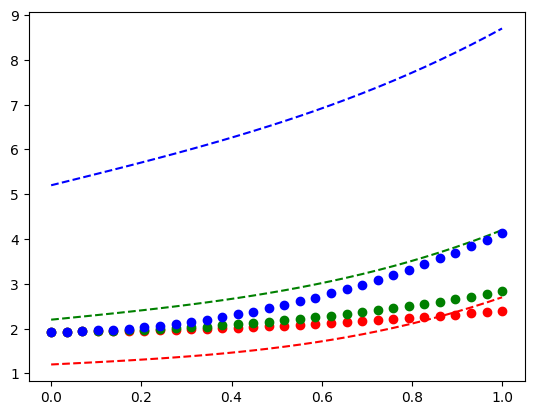

In [39]:
#tree representation
import random
from matplotlib import pyplot as plt
class Bunch(dict):
    def __init__(self, *args, **kwds):
        super(Bunch, self).__init__(*args, **kwds)
        self.__dict__ = self
    
    def __call__(self, x):
        if self.left is None:
            left = x[0]
        else:
            left = self.left(x)
        if self.right is None:
            right = x[1]
        else:
            right = self.right(x)
        return self.op(x[0], x[1], self.weights)
        

ops = (
    lambda x,y,a:a[0]+a[1]*x+a[2]*y,
    lambda x,y,a:a[0]+a[1]*x+a[2]*x**2*y,
    lambda x,y,a:a[0]+a[1]*x+a[2]*x*y**2,
    lambda x,y,a:a[0]+a[1]*x+a[2]*y**2,
    lambda x,y,a:a[0]+a[1]*x+a[2]*x*y,
    lambda x,y,a:a[0]+a[1]*x+a[2]*y**3,
)

test = lambda x: x[0]**3+0.5*x[0]*x[1]+x[1]+0.2

def lse(f1, f2):
    s = []
    for i in range(100):
        x = (random.random(), random.random())
        s.append((f1(x)-f2(x))**2)
    return np.sum(s)/100

tree = lambda left, right, op: op(left, right)

def random_weights():
    return [random.random()*2 for x in range(6)]

def gen_node(lr):
    random.shuffle(lr)
    return Bunch(weights = random_weights(), op=random.choice(ops), left = lr[0], right = lr[1] )

    
iters = 100
error = 1
max_layers = 2
layer = 0
epsilon = 0.001
prev_layer = [None]

cur_layer = []

while error > epsilon and layer < max_layers:
    cur_i = 0
    layer += 1
    while error > epsilon and cur_i < iters:
        cur_i += 1
        node = gen_node([random.choice(prev_layer), None])
        cur_layer.append((node, lse(node, test)))
        if cur_layer[-1][1] < error:
            error = cur_layer[-1][1]
    cur_layer.sort(key=lambda x: x[1])
    prev_layer = list(zip(*cur_layer))[0][:3]
    print(f"{error}:.2f")

    
x = list(np.linspace(0,1,30))
y1 = [[test((a, b)) for a in x] for b in [1,2,5]]
y2 = [[node((a, b)) for a in x] for b in [1,2,5]]
plt.plot(x, y1[0], 'r--', x, y1[1], 'g--', x, y1[2], 'b--', x, y2[0],'ro', x, y2[1],'go', x, y2[2], 'bo')
plt.show()

In [36]:
inputs = tf.constant([1,2,3], shape=(3,1), dtype=tf.float32)
weights = tf.transpose(tf.constant(
    [[1,0,0,1,0,0],[0,1,0,0,1,0],[1,0,1,0,0,0],[0,0,0,1,1,1],[1,0,0,0,1,0],[1,0,0,0,0,1]], dtype = tf.float32))
model = Model(3, weights)

NameError: name 'Model' is not defined

In [37]:
model(inputs)

NameError: name 'model' is not defined

In [183]:
model.layers[0].mask

<tf.Tensor: shape=(6, 3), dtype=int32, numpy=
array([[1, 1, 0],
       [1, 0, 1],
       [1, 1, 0],
       [0, 1, 1],
       [1, 0, 1],
       [0, 1, 1]])>

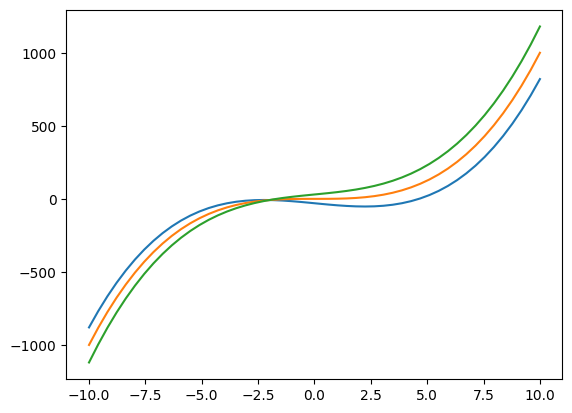

In [43]:
test = lambda x: x[0]**3+0.5*x[0]*x[1]+x[1]+0.2
x = np.linspace(-10,10)
plt.plot(x, [test((a, -30)) for a in x], x, [test((a, 0)) for a in x], x, [test((a, 30)) for a in x])
y0 = [test((a, 0)) for a in x]
np.min(y0) - np.max(y0)

In [196]:
1>None

TypeError: '>' not supported between instances of 'int' and 'NoneType'